# Active contraction

The EMI model is based on a core idea that what happens inside the cells is fundamentally different from what happens outside of the cells. In traditional tissue-level models these are averaged out, which is necessesary for many purposes in terms of having a tractable code running in feasible time. For a handful of cells, however, it is quite feasible to take these differences into account.

One of the core principles in the mechanical EMI model is that the cells contract - and the matrix does not. We assume continuity of displacement across the membrane, so the matrix will kind of "follow" the movement, yet restrict the movement somewhat, especially if it is stiff.

We will use the code from the main repository [emimechanicalmodel](https://github.com/aashildte/emimechanicalmodel/), which is based on FEniCS. We can import all libraries we need in this demo as follows:

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import fenics as f
import emimechanicalmodel as emi_m

f.set_log_level(30)        # less verbatim output from the Newton solver compared to default

You don't really need to know much FEniCS in advance to run the code - we will guide you through what you need to know.

## Geometries and meshes

We can start by reading in the mesh and subdomain information:

In [9]:
mesh_file = "tile_connected_10p0.h5"
mesh, volumes = emi_m.load_mesh(mesh_file)

Mesh and subdomains loaded successfully.
Number of nodes: 335, number of elements: 1364


## Fundamental equations

When we solve the mechanical problem, we want to find a displacement field $\mathbf{u}$ which gives us an _equilibrium of stresses_. We are, essentially, solving for a three-dimensional version of Newton's third law, expressed by Piola-Kirchhoff stress tensor $\mathbf{P}$:

$$\nabla \cdot \mathbf{P} = 0$$

We allow for free contraction on all sides, such that all forces we deal with are generated by the cell itself. In addition, we need to account for stiffness of each subdomain. The stiffer either is, the harder it will be for the cell to contract. We won't go into all the details of the derivation here, but in short, we can express $\mathbf{P}$ as an equilibrium between active and passive forces.

There are two ways we can do this, either following and _active stress_ (which works in an additive manner) or and _active strain_ approach (working in a multiplicative manner). Both are reasonable choices, but the active stress approach might be easier to connect to physiological relevant quantities, while the active strain approach has certain numerical advantages.

### Active stress

Using an active stress approach, we can decompose $\mathbf{P}$ into a passive and an active term:

$$ P = \frac{\partial \Psi_{passive} (F)}{\partial F} + \frac{\partial \Psi_{active} (F)}{\partial F}$$

The active part is, in this code, given in as a driver of the model. In more advanced models it can be dependent on a number of other relevant variables, e.g. calcium dynamics.

The separation of active contribution in the different subdomains is pretty straight forward: We assume that the cells contract – with a non-zero contribution – and that the matrix does not contract. Mathematically we can say that the active tension is zero in the extracellular subdomain:

$$
\Psi_{active} = \begin{cases} \frac{T_{active}(t)}{2} || \mathbf{F} \mathbf{f}_0 ||^2 \qquad \qquad \ x \in \Omega_i \\ 0 \qquad \quad \qquad \qquad \qquad x \in \Omega_e \end{cases}
$$

### Active strain

Using an active strain approach, we do a multiplicative decomposition. 

TODO more here

## Active transient

We will use the force calculated from the Rice model to calculate $T_{active} (t)$ (using the active stress approach) or $\gamma$ (using the active strain approach). Note that this is _weakly_ coupled; we are not giving the local strain (which can be translated to the change in the sarcomere length) back to the Rice model. Physiologically this would have made most sense, but this is a non-trivial task – that no-one so far has been able to do for the EMI model!

We have, for convenience, precalculated the force transient which we will read in for now. Later on, we'll play with some of the parameters to get different active tension transients based on changes in calcium and myofilament dynamics. We can read in, and plot, the pre-calculated values as follows:

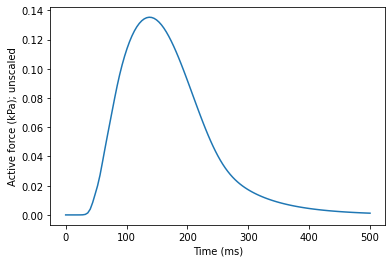

In [16]:
time = np.linspace(0, 500, 125)       # 500 ms with 125 steps

active_precomputed, _ = emi_m.compute_active_component(time)

plt.plot(time, active_precomputed)
plt.xlabel("Time (ms)")
plt.ylabel("Active force (kPa); unscaled")
plt.show()

This is meant to resemble half of a single beat (up t0 500 ms, out of 1000). Note that this is a normalized beat, which needs to be scaled up to resemble contraction in a physiologically relevant range. Doubling the magnitude gives reasonable strain values (about 20 \% shortening of the cell):

In [17]:
active_precomputed *= 2

This is a scaling parameter that, depepnding on your application, might be useful to experiment with.

## Running the EMI model

With the theory explained, let's move on to the actual coding! From the emimechanicalmodel library, we can make an instance of the EMI model which is based on all the equations above - predefined for us. You hence won't need to worry about getting any of the equations right; your main task will be to adjust the different parameters.

We can create one instance like this:

In [18]:
emimodel = emi_m.EMIModel(
            mesh,
            volumes,
            experiment="contraction",
            active_model="active_strain"
        )

length=102.0, width=20.0, height=24.0


The 'mesh' and 'volumes' parameters are given as explained above, and always needs to be provided.

The <code>active_model</code> parameter, which is optional, can either be "active_strain" (which is default) or "active_stress". The two options are fairly interchangable using the default material parameters (if you change both you might go into unexplored territories). Note that for the active strain approach, $\gamma$ has a theoretical upper limit of 1, but realistically shouldn't surpass about 0.3.

# Running a forward simulation

Let's use the active values from above. We can update the active contraction in a for loop, like this, and solve the system in every iteration.

We will track two variables over contraction: The average intracellular strain in the fiber direction, and the intracellular stress in the fiber direction. Mathematically, we are tracking the values

\begin{equation}
\overline{E_{ff}} = \frac{\int_{\Omega_i} \mathbf{f} \cdot (\mathbf{E} \mathbf{f}) \mathrm{d}\mathbf{X}}{\int_{\Omega i} \mathrm{d}\mathbf{X}}
\qquad
\text{and}
\qquad
    \overline{\sigma_{ff}} = \frac{\int_{\Omega_i} \mathbf{f} \cdot (\mathbf{\sigma} \mathbf{f}) \mathrm{d}\mathbf{X}}{\int_{\Omega i} \mathrm{d}\mathbf{X}}
    \label{eq:cm_stress}
\end{equation}

and while it would certainly be possible to perform these integrals "manually" by writing out the Fenics code for each, this is already implemented so we will simply do this using in-built functions.

In [19]:
fiber_dir_strain_i = np.zeros_like(active_precomputed)
fiber_dir_stress_i = np.zeros_like(active_precomputed) 
subdomain_id = 1         # intracellular subdomain

# then run the simulation
for step, a_str in enumerate(active_precomputed):
    print(step, a_str)
    
    if (step-1) % 10 == 0:
        print(f"Simulating {step + 1} / {len(active_precomputed)}" + \
              f"with active tension parameter {a_str:.5f}")
    
    emimodel.update_active_fn(a_str)
    emimodel.solve()
    
    fiber_dir_strain_i[step] = \
        emimodel.evaluate_subdomain_strain_fibre_dir(subdomain_id)
    fiber_dir_stress_i[step] = \
        emimodel.evaluate_subdomain_stress_fibre_dir(subdomain_id)


0 3.781739900855736e-06
Simulating 1 / 125
1 3.5991966479457216e-06
2 3.426442869898417e-06
3 3.2920374678299115e-06
4 3.6646372153445853e-06
5 8.722007297891912e-06
6 3.915726850445443e-05
7 0.0001628839351832139
8 0.0007159948858377434
9 0.002730655764761942
10 0.007846268731697458
Simulating 11 / 125
11 0.016957442791340628
12 0.028309567356360494
13 0.040007688280082665
14 0.05459925725501705
15 0.07237376912922881
16 0.09063854718282123
17 0.10844682606853351
18 0.1258803793559886
19 0.1432815663624048
20 0.16057086301098009
Simulating 21 / 125
21 0.17705838604686924
22 0.1920538682353735
23 0.20538753370299298
24 0.21723440583631481
25 0.22775227420099875
26 0.2370054026243826
27 0.2450339840713096
28 0.25188428463853496
29 0.25760296778162706
30 0.26223392202682727
Simulating 31 / 125
31 0.2658176329045258
32 0.26839076268618206
33 0.26998530774418067
34 0.27062860263940447
35 0.27034319650763244
36 0.26914479883006903
37 0.2670245681300839
38 0.26405910208368294
39 0.2603058609

We can next plot these, let's do them in two separate subplots as they have different units:

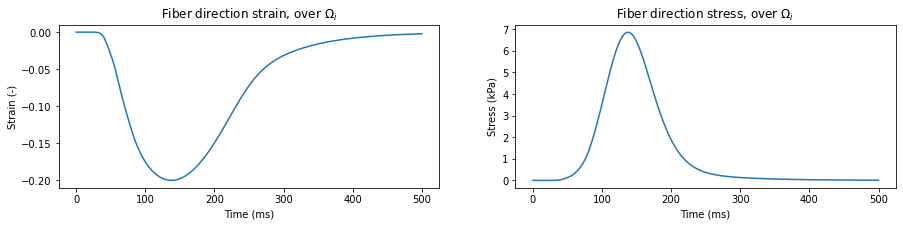

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

axes[0].plot(time, fiber_dir_strain_i)
axes[1].plot(time, fiber_dir_stress_i)

axes[0].set_xlabel("Time (ms)")
axes[1].set_xlabel("Time (ms)")
axes[0].set_ylabel("Strain (-)")
axes[1].set_ylabel("Stress (kPa)")

axes[0].set_title(r"Fiber direction strain, over $\Omega_i$")
axes[1].set_title(r"Fiber direction stress, over $\Omega_i$")

plt.show()

In similar manners we can track stresses and strain values in the extracellular subdomain, identified with the number $0$. We also have in-built functions for tracking sheet and normal direction values, using functions <code>evaluate_subdomain_strain_sheet_dir</code>, <code>evaluate_subdomain_strain_normal_dir</code>, <code>evaluate_subdomain_stress_sheet_dir</code>, and <code>evaluate_subdomain_stress_normal_dir</code>.